In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import warnings
import re
import datetime
from package.utils import profile_data ,DotDict, timer, get_config, load_data, merge_data 

## Autoencoder

In [3]:
# from package.model_deep import (generate_mock_data, 
#                                 prepare_data,
#                                 set_seed,
#                                 Autoencoder,
#                                 train_autoencoder,
#                                 plot_learning_curve,
#                                 detect_anomalies,
#                                 extract_embeddings,
#                                 plot_latent_space
#                                 )

In [4]:
from package.model_deep_ae import (set_seed,
                                generate_mock_data,
                                expand_rule_columns,
                                subset_by_timeunit,
                                split_train_test,
                                prepare_train_val_test_data,
                                Autoencoder,
                                train_autoencoder,
                                plot_learning_curve,
                                get_reconstruction_error,
                                plot_threshold_vs_metric_percentile,
                                flag_anomalies,
                                detect_anomalies,
                                tune_autoencoder_grid,
                                extract_embeddings,
                                plot_latent_space,
                                create_pack_results,
                                append_experiment_results
                                )

### Prep data

In [5]:
mock1 = generate_mock_data(n_sales=10000, n_rules=10, fraud_ratio=0.05, seed=42)
mock1

function: generate_mock_data is starting...
function: generate_mock_data successfully executed at 1.2720863819122314s


,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9995,l36,0,0.647493,-0.163831,-1.743780,1.184970,-0.193500,-1.273190,0.773532,-1.803990,2.209333,-0.800634
59996,9996,l36,0,-0.716390,1.700367,-0.933375,0.191027,-1.348096,2.584121,-0.054343,-1.355835,1.124099,0.609250
59997,9997,l36,0,1.066770,-1.592284,-1.706892,1.178747,0.985029,0.364593,-2.039914,-0.325981,0.478952,0.808948
59998,9998,l36,0,1.622065,-0.303766,1.377932,-0.777375,-0.179569,0.607243,-1.106324,-0.591367,0.501293,0.450664


In [6]:
df_transformed = expand_rule_columns(mock1)
df_transformed

function: expand_rule_columns is starting...
function: expand_rule_columns successfully executed at 0.42163944244384766s


,sales_id,flag_fraud,rule_10_l12,rule_10_l24,rule_10_l3,rule_10_l36,rule_10_l6,rule_10_l9,rule_1_l12,rule_1_l24,...,rule_8_l3,rule_8_l36,rule_8_l6,rule_8_l9,rule_9_l12,rule_9_l24,rule_9_l3,rule_9_l36,rule_9_l6,rule_9_l9
0,0,0,-0.943490,0.000232,0.783160,0.668797,0.960825,0.888457,-0.389376,0.583561,...,-0.278373,2.053579,0.455672,-0.069470,0.495704,0.001691,0.772848,1.665550,0.385248,-0.944372
1,1,1,4.692913,4.551202,1.086816,3.403392,5.183808,1.615426,2.214356,-0.011207,...,3.582941,-0.468026,2.011123,3.757316,2.700979,-0.738528,2.306755,0.177472,3.777520,3.757815
2,2,0,-0.090432,0.162957,-0.284626,1.460788,0.862283,0.239878,-0.033178,0.214724,...,2.418778,-0.601681,0.202997,2.124338,2.314027,-0.759213,1.495458,-0.912673,-0.432277,-0.981344
3,3,0,-0.474335,-0.921535,0.008858,0.198231,0.106144,-0.716708,-0.282492,-0.336470,...,0.805575,0.768310,-1.021580,-1.304657,0.012273,-2.042267,0.975823,1.258121,-0.668648,0.743399
4,4,0,0.216357,0.160711,-0.380456,-0.865218,0.443058,0.023325,-1.395400,-0.888219,...,2.159121,-0.920259,0.253299,0.587801,-0.308097,-0.009286,0.091315,-1.773001,0.756075,-0.458285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0.375382,-1.835668,-0.044578,-0.800634,-0.630433,-0.276283,2.580578,-1.781299,...,0.135087,-1.803990,0.191417,0.677831,1.198868,-0.298484,-0.032698,2.209333,0.449176,-0.458590
9996,9996,0,0.345934,-1.321427,-2.077919,0.609250,0.135422,0.709128,-0.499775,-0.600470,...,0.136357,-1.355835,0.836549,-1.048457,0.901520,0.958509,0.467324,1.124099,-0.847919,-1.218175
9997,9997,0,-0.185466,-0.474796,-0.171683,0.808948,0.278778,1.366620,-1.171032,0.312918,...,-0.874977,-0.325981,0.455277,1.512830,-0.218674,-0.583616,-0.052822,0.478952,-2.058627,0.809383
9998,9998,0,-0.992855,1.335352,-0.272822,0.450664,0.403903,0.112418,-0.819924,-0.590858,...,-0.698919,-0.591367,0.020615,-0.224661,0.135384,0.522100,-0.929514,0.501293,-0.439973,-1.102105


In [7]:
df_subset = subset_by_timeunit(df_transformed, ["l3"])
df_subset

function: subset_by_timeunit is starting...
function: subset_by_timeunit successfully executed at 0.001275777816772461s


,sales_id,flag_fraud,rule_10_l3,rule_1_l3,rule_2_l3,rule_3_l3,rule_4_l3,rule_5_l3,rule_6_l3,rule_7_l3,rule_8_l3,rule_9_l3
0,0,0,0.783160,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848
1,1,1,1.086816,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755
2,2,0,-0.284626,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458
3,3,0,0.008858,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823
4,4,0,-0.380456,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,-0.044578,-1.529631,1.238310,-0.532892,0.190398,0.422554,-0.023546,-1.133380,0.135087,-0.032698
9996,9996,0,-2.077919,-0.229829,0.674063,1.617860,1.771565,0.757900,0.673849,-1.540880,0.136357,0.467324
9997,9997,0,-0.171683,1.911644,-0.083414,-0.863277,-1.034273,0.248429,0.416630,1.336392,-0.874977,-0.052822
9998,9998,0,-0.272822,-0.438518,-0.747820,1.957480,0.877297,0.099010,0.422686,0.969281,-0.698919,-0.929514


In [8]:
train_all_df, test_df = split_train_test(df_subset)

function: split_train_test is starting...
function: split_train_test successfully executed at 0.004562854766845703s


In [9]:
train_all_df

,sales_id,flag_fraud,rule_10_l3,rule_1_l3,rule_2_l3,rule_3_l3,rule_4_l3,rule_5_l3,rule_6_l3,rule_7_l3,rule_8_l3,rule_9_l3
0,3630,0,-0.234773,1.747087,-0.092075,0.487540,0.031593,-0.307526,-0.024198,0.769346,-0.053467,-0.160935
1,5986,0,1.327322,0.506857,-0.779419,0.070295,-0.504043,-0.643050,0.472607,-0.935056,0.520798,0.309667
2,7036,0,0.363375,-0.785461,2.390482,-0.646937,-0.624096,-0.985203,0.881314,-0.278975,0.813936,1.154796
3,628,0,-0.483484,0.326381,1.361037,0.038895,0.211381,1.182895,-1.544455,0.520176,-0.011590,0.566057
4,6352,0,-0.107302,0.829223,-0.073166,0.387465,-1.018486,-1.000645,-0.381408,0.358372,-0.777887,1.069188
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9252,0,-1.774210,-0.032849,0.705536,-0.446116,-1.258364,0.065479,-1.865180,2.542054,1.045306,0.319269
7996,5428,0,-1.243773,-1.069535,-0.434893,-0.511010,1.220962,-0.214250,-0.373091,1.128805,1.349662,-0.831471
7997,5860,0,0.055937,0.767501,0.090850,2.141473,-0.599212,-1.336953,0.303780,0.583323,-0.768976,0.960491
7998,5684,0,0.245012,-0.621496,-1.986395,0.037237,0.024650,-0.314851,-0.620767,-0.273870,-1.319686,1.778506


In [10]:
train_all_df['flag_fraud'].value_counts()

flag_fraud
0    7621
1     379
Name: count, dtype: int64

In [11]:
train_all_df['flag_fraud'].value_counts(normalize=True)

flag_fraud
0    0.952625
1    0.047375
Name: proportion, dtype: float64

In [12]:
test_df

,sales_id,flag_fraud,rule_10_l3,rule_1_l3,rule_2_l3,rule_3_l3,rule_4_l3,rule_5_l3,rule_6_l3,rule_7_l3,rule_8_l3,rule_9_l3
0,8751,0,-0.014066,-1.393845,-0.549546,0.717000,0.399731,0.284135,1.534209,0.150712,0.145437,1.170655
1,3108,0,-0.407000,-0.902097,-0.201197,-0.692537,-0.932545,0.674499,1.033911,0.509996,-0.438105,-0.662554
2,7395,0,-0.379389,-0.136750,1.156046,-0.540447,0.111782,0.335219,0.705519,0.472408,0.395685,-0.477659
3,1373,0,-0.169135,-1.773354,1.291998,-0.447097,1.554840,0.196109,2.025284,0.606322,-1.432020,-0.614415
4,1858,0,-0.294788,0.087962,-0.316080,1.132134,-0.878668,-1.731316,-1.357284,0.994168,-0.969557,0.397844
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3178,0,0.988216,0.597874,-1.548680,-0.699116,0.820012,0.831763,1.175272,-2.019722,0.296013,-0.257685
1996,9980,0,0.051826,0.232610,-0.141040,-0.958353,0.670028,-0.126161,0.865351,-0.671043,-0.842563,0.100661
1997,1440,1,1.460228,3.279685,2.484863,4.937438,0.862143,1.526850,2.337857,3.426782,2.285128,2.291597
1998,8684,0,-0.374381,0.848555,-0.475394,-0.760063,2.249280,-0.196480,0.666618,-0.119712,-0.185424,1.258852


In [13]:
test_df['flag_fraud'].value_counts()

flag_fraud
0    1905
1      95
Name: count, dtype: int64

In [14]:
test_df['flag_fraud'].value_counts(normalize=True)

flag_fraud
0    0.9525
1    0.0475
Name: proportion, dtype: float64

In [15]:
X_train, X_val, X_test, y_test = prepare_train_val_test_data(train_all_df, test_df)

function: prepare_train_val_test_data is starting...
function: prepare_train_val_test_data successfully executed at 0.005841493606567383s


In [16]:
X_train.shape # Train on non-fraud only

(6096, 10)

In [17]:
X_val.shape # val non-fraud only (sep from train)

(1525, 10)

In [18]:
X_test.shape # Test on all agent, even if it contains fraud, because you’re looking at the reconstruction error to flag anomalies

(2000, 10)

In [19]:
y_test.shape

(2000,)

### defining the architecture of the autoencoder
- Building the layers (nn.Linear, nn.ReLU, etc.)
- Structuring the encoder and decoder using nn.Sequential
- Defining the forward() function for how data flows through the network
  <br><br>
**But this does not train anything yet.**

In [20]:
X_train.shape[1] # จำนวน features

10

In [21]:
set_seed(42)
model_test = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=True)

# This is only used for testing the model architecture, not training or evaluating on real data.
x = torch.randn(5, X_train.shape[1]) 
output = model_test(x)

Input: torch.Size([5, 10])
Encoder layer 0: torch.Size([5, 6])
Encoder layer 1: torch.Size([5, 6])
Encoder layer 2: torch.Size([5, 4])
Encoder layer 3: torch.Size([5, 4])
Encoder layer 4: torch.Size([5, 3])
Latent space: torch.Size([5, 3])
Decoder layer 0: torch.Size([5, 4])
Decoder layer 1: torch.Size([5, 4])
Decoder layer 2: torch.Size([5, 6])
Decoder layer 3: torch.Size([5, 6])
Decoder layer 4: torch.Size([5, 10])
Output: torch.Size([5, 10])


In [22]:
output

tensor([[ 0.6478, -0.0272,  0.0387,  0.2780, -0.0180, -0.2639,  0.3674,  0.0223,
         -0.1578, -0.3743],
        [ 0.6395, -0.0260,  0.0344,  0.2788, -0.0222, -0.2659,  0.3624,  0.0165,
         -0.1559, -0.3785],
        [ 0.6344, -0.0253,  0.0318,  0.2793, -0.0248, -0.2672,  0.3593,  0.0130,
         -0.1548, -0.3811],
        [ 0.6336, -0.0252,  0.0314,  0.2794, -0.0252, -0.2674,  0.3589,  0.0125,
         -0.1546, -0.3815],
        [ 0.6464, -0.0270,  0.0380,  0.2781, -0.0187, -0.2642,  0.3666,  0.0213,
         -0.1575, -0.3750]], grad_fn=<AddmmBackward0>)

#### train model to learn normal pattern
It trains an Autoencoder model to reconstruct its input, using mean squared error (MSE) as the loss. 
This lets the model learn the “normal pattern” of your data which you'll later use to detect anomalies.

#### loss  function and optimizer

https://docs.pytorch.org/docs/stable/nn.html#loss-functions

| Loss Function                                   | When to Use / Pros                                                                                      |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Mean Absolute Error (MAE)** (`nn.L1Loss()`)   | Less sensitive to outliers than MSE; good if you want robustness to large errors.                       |
| **Binary Cross-Entropy (BCE)** (`nn.BCELoss()`) | Use if input features are binary or normalized between 0 and 1. Often used in Variational Autoencoders. |
| **Huber Loss** (`torch.nn.SmoothL1Loss`)        | Combines benefits of MSE and MAE; less sensitive to outliers than MSE.                                  |
| **Custom Loss**                                 | You can define custom losses, e.g., weighted reconstruction errors or perceptual losses for images.     |


https://docs.pytorch.org/docs/stable/optim.html

| Optimizer                     | Description / When to Use                                                             |
| ----------------------------- | ------------------------------------------------------------------------------------- |
| **SGD** (`optim.SGD`)         | Classic stochastic gradient descent; slower but sometimes better generalization.      |
| **RMSProp** (`optim.RMSprop`) | Good for recurrent networks and non-stationary objectives; adapts learning rate.      |
| **AdamW** (`optim.AdamW`)     | Variant of Adam with better weight decay handling; often improves regularization.     |
| **Adagrad** (`optim.Adagrad`) | Adapts learning rate based on frequency of parameter updates; useful for sparse data. |


In [23]:
set_seed(42)

model = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=False)
trained_model , train_losses, val_losses= train_autoencoder(model=model, 
                                                            X_train=X_train,
                                                            X_val = X_val, 
                                                            epochs=50, 
                                                            batch_size=64)

function: train_autoencoder is starting...
Epoch [1/50] - Train Loss: 1.0538, Val Loss: 1.0388
Epoch [2/50] - Train Loss: 0.9924, Val Loss: 0.9658
Epoch [3/50] - Train Loss: 0.9323, Val Loss: 0.9203
Epoch [4/50] - Train Loss: 0.8734, Val Loss: 0.8584
Epoch [5/50] - Train Loss: 0.8350, Val Loss: 0.8394
Epoch [6/50] - Train Loss: 0.8212, Val Loss: 0.8303
Epoch [7/50] - Train Loss: 0.8134, Val Loss: 0.8250
Epoch [8/50] - Train Loss: 0.8088, Val Loss: 0.8220
Epoch [9/50] - Train Loss: 0.8036, Val Loss: 0.8184
Epoch [10/50] - Train Loss: 0.7980, Val Loss: 0.8138
Epoch [11/50] - Train Loss: 0.7905, Val Loss: 0.8064
Epoch [12/50] - Train Loss: 0.7860, Val Loss: 0.8045
Epoch [13/50] - Train Loss: 0.7807, Val Loss: 0.8043
Epoch [14/50] - Train Loss: 0.7796, Val Loss: 0.8020
Epoch [15/50] - Train Loss: 0.7765, Val Loss: 0.7982
Epoch [16/50] - Train Loss: 0.7705, Val Loss: 0.7874
Epoch [17/50] - Train Loss: 0.7514, Val Loss: 0.7512
Epoch [18/50] - Train Loss: 0.7135, Val Loss: 0.7211
Epoch [19/50

In [24]:
trained_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=10, bias=True)
  )
)

What the graph shows:
- X-axis: Epochs (how many times the model has seen the training data)
- Y-axis: Loss (how well the model reconstructs input — lower is better)

There are two curves:
- Training Loss: Error on the training data the model learned from
- Validation Loss: Error on unseen data (validation set)

Goal: Both losses should decrease and stay close to each other.

If validation loss starts increasing while training loss decreases, it’s a sign to stop training or apply techniques to reduce overfitting.

function: plot_learning_curve is starting...


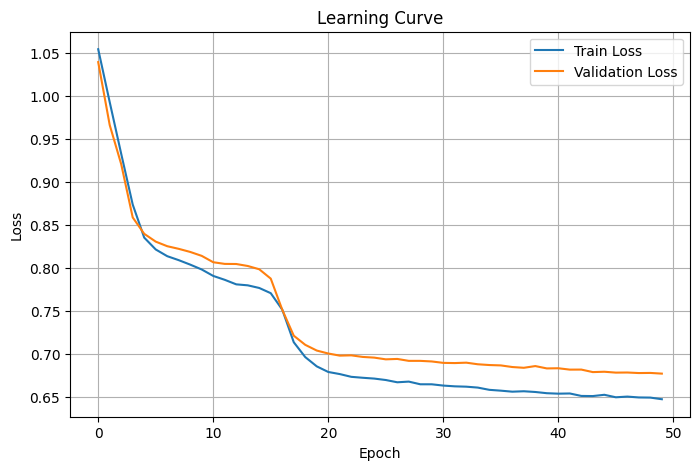

function: plot_learning_curve successfully executed at 0.26158595085144043s


In [25]:
plot_learning_curve(train_losses, val_losses)

### Grid search

| Parameter      | What it controls                  | Why tune it?                         |
| -------------- | --------------------------------- | ------------------------------------ |
| encoding\_dim  | Size of compressed representation | Balance between detail & compression |
| hidden\_layers | Number & size of layers in model  | Model complexity & learning power    |
| activation     | Function deciding neuron output   | How model learns patterns            |
| batch\_size    | Number of samples per update      | Stability & speed of training        |
| lr             | Step size for weight updates      | Training speed & convergence         |


In [26]:
param_grid = {
    "encoding_dim": [2, 3, 4],
    "hidden_layers": [[8], [8, 4], [16, 8]],
    "activation": [nn.ReLU, nn.Tanh],
    "batch_size": [32, 64],
    "lr": [1e-3, 5e-4]
}

## รันนานมาก ขอคอมมเม้นไว้ก่อน
# best_model, best_config, best_val_loss = tune_autoencoder_grid(
#     X_train=X_train,    # your normal train data (numpy or pd.DataFrame)
#     X_val=X_val,        # your normal validation data (numpy or pd.DataFrame)
#     param_grid=param_grid,
#     epochs=50,
#     verbose=True
# )

# print("Best config found:", best_config)

### Predict and Test Performance

- หลังจากได้โมเดล เราลองใส่ X_test เข้าไปเพื่อให้ได้  y_predict
- แล้วทดสอบผลกับ y_test

In [27]:
trained_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=10, bias=True)
  )
)

In [28]:
# 1. Compute reconstruction error
recon_error = get_reconstruction_error(trained_model, X_test)
recon_error

function: get_reconstruction_error is starting...
function: get_reconstruction_error successfully executed at 0.0019500255584716797s


array([0.25404861, 0.38153313, 0.22160521, ..., 3.67322559, 0.36781553,
       0.5722689 ], shape=(2000,))

function: plot_threshold_vs_metric_percentile is starting...


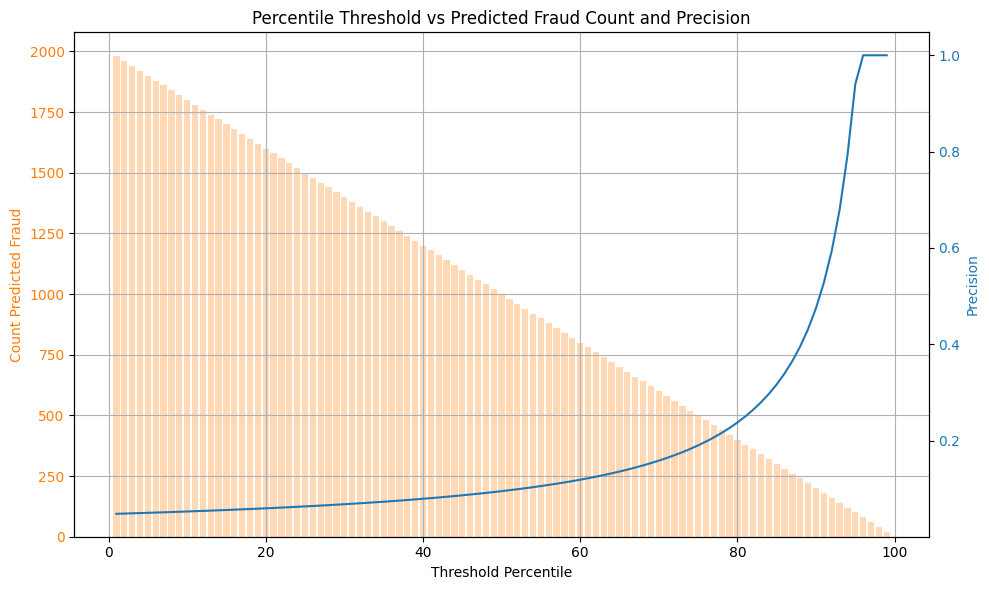

function: plot_threshold_vs_metric_percentile successfully executed at 0.4930379390716553s


In [29]:
# 2. Explore thresholds with plot
plot_threshold_vs_metric_percentile(y_test, recon_error, metric='precision')

function: plot_threshold_vs_metric_percentile is starting...


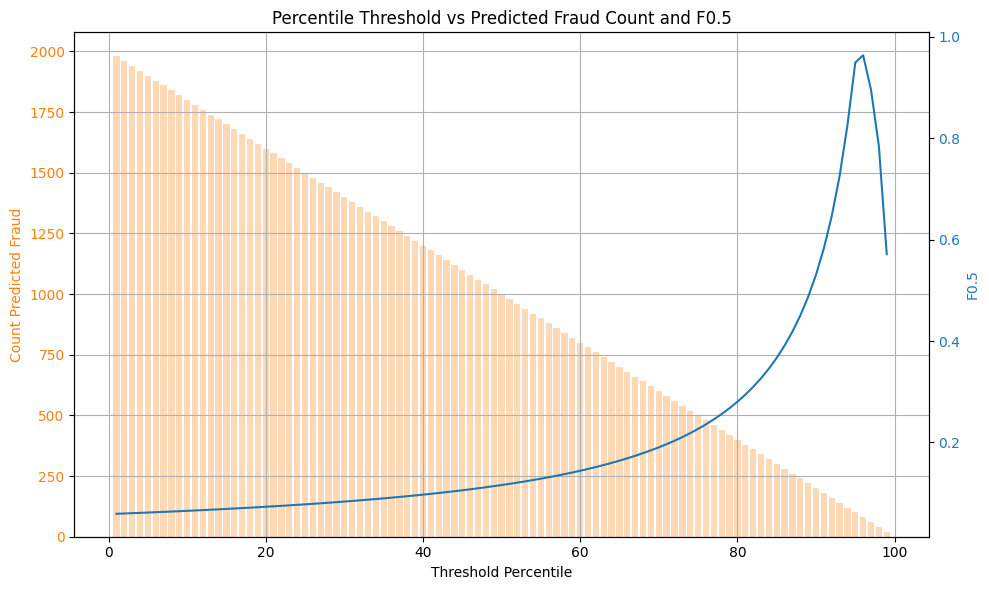

function: plot_threshold_vs_metric_percentile successfully executed at 0.4872860908508301s


In [30]:
plot_threshold_vs_metric_percentile(y_test, recon_error, metric='f0.5')

In [31]:
# Pick a threshold (e.g., 95th percentile of normal errors)
threshold = np.percentile(recon_error[y_test == 0], 95)

threshold

np.float64(1.3485582769037432)

In [32]:
# 3. Flag anomalies
y_pred = flag_anomalies(recon_error, threshold)
y_pred

function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.00015020370483398438s


array([0, 0, 0, ..., 1, 0, 0], shape=(2000,))

In [33]:
# เราใส่ Testดาต้าทั้งหมด (f / nf) เข้าไปเพื่อเทส (assume ว่าตัวโมเดลเรียนรู้ pattern ความปกติมาแล้ว)
# recon_error, predicted_fraud = detect_anomalies(trained_model, X_test, y_test,threshold_quantile=95)
_, _ = detect_anomalies(trained_model, X_test, y_test,threshold_quantile=95)

function: detect_anomalies is starting...
Threshold (q=95): 1.3486
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1905
           1       0.50      1.00      0.66        95

    accuracy                           0.95      2000
   macro avg       0.75      0.97      0.82      2000
weighted avg       0.98      0.95      0.96      2000

function: detect_anomalies successfully executed at 0.022727489471435547s


### Embeddings

In [34]:
embeddings = extract_embeddings(trained_model, X_test)

function: extract_embeddings is starting...
function: extract_embeddings successfully executed at 0.002393484115600586s


In [35]:
embeddings

array([[ -3.5199323,  -3.9722545,  -5.2691216],
       [ -3.499177 ,  -3.948274 ,  -3.292949 ],
       [ -3.200121 ,  -5.0832443,  -3.850948 ],
       ...,
       [  2.2080142, -19.367874 ,  -7.6157165],
       [  0.6828423,  -6.869085 ,  -4.359135 ],
       [ -3.6924906,  -3.3253422,  -4.3270016]],
      shape=(2000, 3), dtype=float32)

function: plot_latent_space is starting...


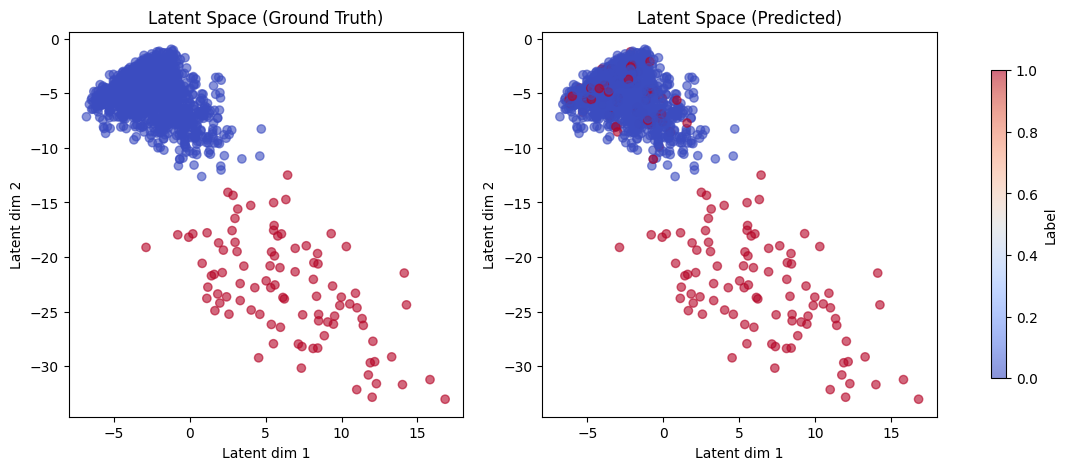

function: plot_latent_space successfully executed at 0.33299970626831055s


In [36]:
# embeddings = model.encode(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# 1. Only true labels
# plot_latent_space(embeddings, y_test=y_test, encoding_dim=3)

# # 2. Only predicted labels
# plot_latent_space(embeddings, y_pred=predicted_fraud, encoding_dim=3)

# # 3. Compare both
plot_latent_space(embeddings, y_test=y_test, y_pred=y_pred, encoding_dim=2)

In [39]:
pd.DataFrame({
    "y_test": pd.Series(y_test).value_counts(),
    "y_pred": pd.Series(y_pred).value_counts()
}).fillna(0).astype(int)

,y_test,y_pred
0,1905,1809
1,95,191


### Packing

In [42]:
results_df = create_pack_results(test_df, y_pred, experiment_name='ae_l3_1')
results_df

function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.000652313232421875s


,sales_id,ae_l3_1
0,8751,0
1,3108,0
2,7395,0
3,1373,0
4,1858,0
...,...,...
1995,3178,0
1996,9980,0
1997,1440,1
1998,8684,0


In [ ]:
# # First experiment
# results_df = create_results_df_wide(test_df, y_pred_ae1, experiment_name='ae_1')

# # Second experiment
# results_df = append_experiment_results(results_df, y_pred_ae2, experiment_name='ae_2')

# # Third experiment
# results_df = append_experiment_results(results_df, y_pred_ae3, experiment_name='ae_3')

# results_df
